
# Float vertical position control, realistic float behavior


---

## Equations of motion

For basics about float dynamics go [here](https://github.com/apatlpo/cognac/blob/master/instrum/float_dynamics_basics.ipynb)

We assume now that the float has the ability to control its volume between two bounds $V+v_{min}$ and $V+v_{max}$
with a precision $dv$.


In [1]:
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np
from scipy.interpolate import interp1d
import time
from copy import deepcopy

from matplotlib import animation, rc
from IPython.display import HTML

from float_lib import *

WOA water profile at lon=-50, lat=40


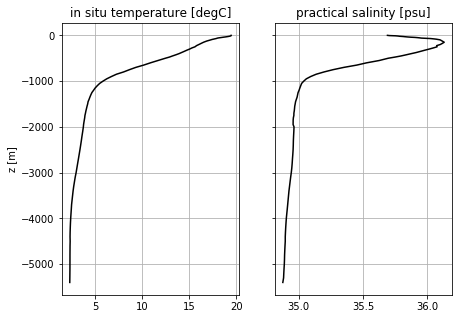

In [2]:
# select a water profile
w = waterp(lon=-50.,lat=40.)
print(w)
#w.show_on_map()

--- 
## Stable float with varying volume

85.8 g were added to the float in order to be at equilibrium at 252 dbar 

Float parameters: 
  L     = 0.40 m      - float length
  a     = 0.05 m      - float radius
  m     = 3.23 kg     - float radius
  V     = 3.14e+03 cm^3   - float volume
  gamma = 2.00e-06 /dbar  - mechanical compressibility
  alpha = 7.00e-05 /degC  - thermal compressibility
  temp0 = 1.50e+01 /degC  - reference temperature
Piston parameters and state: 
  vmin = -6.60 cm^3      - min volume
  vmax = 16.09 cm^3      - max volume
  dv   = 0.23 cm^3      - volume increments
  v    = 16.09 cm^3      - present volume addition

Acceleration and velocity bounds (zmin=-500m,zmax=0m):
fmax/m=3.5e-02 m^2/s, fmin/m= -1.3e-02 m^2/s, wmax= 11.9 cm/s
For accelerations, equivalent speed reached in 1min:
  fmax 2.1e+02 cm/s, fmin/m= -8.0e+01 cm/s
Acceleration after an elementary piston displacement: 7.1e-04 m^2/s
  corresponding speed and displacement after 1 min: 4.3e-02 m/s, 1.3e+00 m 



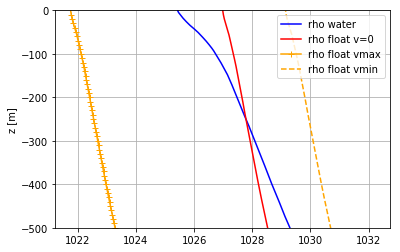

In [3]:
# Init now active control of the vertical position

#
z=np.arange(-1000.,0.,1.)
rho_w, p, temp = w.get_rho(z), w.get_p(z), w.get_temp(z)

#
fs = autonomous_float()
# adjust mass to be at equilibrium at -250m
iz = np.argmin(np.abs(z+250))
fs.adjust_m(p[iz],temp[iz],rho_w[iz])
# set vmax such that the float is neutral at the surface
iz = np.argmin(np.abs(z+0))
vmax = fs.adjust_balast(p[iz],temp[iz],rho_w[iz])
# set vmin such that the float is neutral at 1000m depth
iz = np.argmin(np.abs(z+1000))
vmin = fs.adjust_balast(p[iz],temp[iz],rho_w[iz])
# adjust vmax to be confortable at the surface - arbitrary !!!
vmax = vmax + (vmax-vmin)
# assume 100 increments in volume - arbitrary !!!
dv = (vmax-vmin)/100. # corresponds to 2000m/100 = 20m
#
fs.init_piston(vmin,vmax,dv,v=vmax)
print(fs)

# compute bounds on motions
fmax, fmin, afmax, wmax = fs.compute_bounds(w,-500.)

# show densities
plt.figure()
ax = plt.subplot(111)
#
iz = np.argmin(np.abs(z+250))
rho_f=fs.rho(p,temp,v=0.)
rho_f_vmax=fs.rho(p,temp,v=fs.piston.vmax)
rho_f_vmin=fs.rho(p,temp,v=fs.piston.vmin)
#
ax.plot(rho_w,z,'b',label='rho water')
ax.plot(rho_f,z,'r',label='rho float v=0')
ax.plot(rho_f_vmax,z,'-+',color='orange',label='rho float vmax',markevery=10)
#ax.plot(rho_f_vmax[::20],z[::20],'+',color='orange',label='rho float vmax')
ax.plot(rho_f_vmin,z,'--',color='orange',label='rho float vmin')
ax.legend()
ax.set_ylim((-500,0.))
ax.set_ylabel('z [m]')
ax.grid()


---
## Unstable float with varying volume

46.6 g were added to the float in order to be at equilibrium at 252 dbar 

Float parameters: 
  L     = 0.40 m      - float length
  a     = 0.05 m      - float radius
  m     = 3.19 kg     - float radius
  V     = 3.14e+03 cm^3   - float volume
  gamma = 5.00e-05 /dbar  - mechanical compressibility
  alpha = 0.00e+00 /degC  - thermal compressibility
  temp0 = 1.50e+01 /degC  - reference temperature
Piston parameters and state: 
  vmin = -170.43 cm^3      - min volume
  vmax = 105.72 cm^3      - max volume
  dv   = 2.76 cm^3      - volume increments
  v    = 105.72 cm^3      - present volume addition

Acceleration and velocity bounds (zmin=-500m,zmax=0m):
fmax/m=4.4e-01 m^2/s, fmin/m= -6.5e-01 m^2/s, wmax= 51.0 cm/s
For accelerations, equivalent speed reached in 1min:
  fmax 2.6e+03 cm/s, fmin/m= -3.9e+03 cm/s
Acceleration after an elementary piston displacement: 9.4e-03 m^2/s
  corresponding speed and displacement after 1 min: 5.6e-01 m/s, 1.7e+01 m 

-1.000000,1.025437e+03,9.818329e+

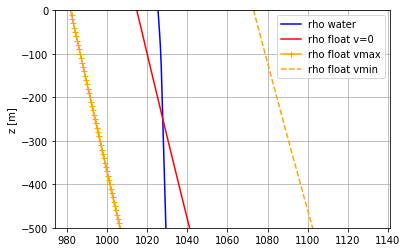

In [4]:

#
fu = autonomous_float(gamma=50.e-6,alpha=0.)
# adjust mass to be at equilibrium at -250m
iz = np.argmin(np.abs(z+250))
fu.adjust_m(p[iz],temp[iz],rho_w[iz])

# note conditions on vmin and vmax are reversed compare to the stable case:
#   vmin is now determined by flottation at the surface and vmax by neutrality at depth
# set vmin such that the float is neutral at the surface
iz = np.argmin(np.abs(z+0))
vmin = fu.adjust_balast(p[iz],temp[iz],rho_w[iz])
# set vmax such that the float is neutral at 1000m depth
iz = np.argmin(np.abs(z+1000))
vmax = fu.adjust_balast(p[iz],temp[iz],rho_w[iz])
# adjust vmin to be confortable at the surface - arbitrary !!!
vmin = vmin - (vmax-vmin)
# assume 100 increments in volume - arbitrary !!!
dv = (vmax-vmin)/100. # corresponds to 2000m/100 = 20m
#
fu.init_piston(vmin,vmax,dv,v=vmax)
print(fu)

# compute bounds on motions
fmax, fmin, afmax, wmax = fu.compute_bounds(w,-500.)

# show densities
plt.figure()
ax = plt.subplot(111)
#
iz = np.argmin(np.abs(z+250))
rho_f=fu.rho(p,temp,v=0.)
rho_f_vmax=fu.rho(p,temp,v=fu.piston.vmax)
rho_f_vmin=fu.rho(p,temp,v=fu.piston.vmin)
print('%f,%e,%e,%e'%(z[-1],rho_w[-1],rho_f_vmax[-1],rho_f_vmin[-1]))
#
ax.plot(rho_w,z,'b',label='rho water')
ax.plot(rho_f,z,'r',label='rho float v=0')
ax.plot(rho_f_vmax,z,'-+',color='orange',label='rho float vmax',markevery=10)
ax.plot(rho_f_vmin,z,'--',color='orange',label='rho float vmin')
ax.legend()
ax.set_ylim((-500,0.))
ax.set_ylabel('z [m]')
ax.grid()


---

---

## !!! What follows is ongoing work !!!




---

## Control

Let's reformulate with Luc's notations first ...


The **system state vector** is given by:

$$
\begin{align*}
\underline{x} &= 
\left(\begin{array}{c} 
x_1\\
x_2\\
x_3
\end{array}\right)
=
\left(\begin{array}{c} 
z_f\\
dz_f/dt\\
V+v
\end{array}\right)
\end{align*}
$$

**Bounds**:
- Vertical position: We want $z_f$ to be within $[-500\mathrm{m},0]$
- Speed: we need first an estimate of the maximum buoyancy force that can exerted on the float. The adjustable volume is such that the density of the float can be that of the water at the surface and at $-500$m. This may lead to the following bound on the float velocity:

$$
\begin{align*}
\max | w_f | &= \sqrt{L_v g \max \Big | 1 - \frac{\rho_w}{\rho_f} \big | } , \\
&=? \sqrt{L_v g \Big (1 - \frac{\rho_w(0)}{\rho_w(-500m)} \Big ) }.
\end{align*}
$$

- Acceleration: the maximum acceleration is given by the maximum buoyancy force that may be applied on the float:

$$
\begin{align*}
\max \Big | \frac{dw_f}{dt} \Big | &= g \max \Big | 1 - \frac{\rho_w}{\rho_f} \Big |
\end{align*}
$$

- The adjustable volume evolves between $v_\min$  and $v_\max$.


The **control** is given by: $u=\partial_t v$

The **equation of the float evolution** are then:

$$
\begin{align*}
d\underline{x}/dt &= 
\left(\begin{array}{c} 
dx_1/dt\\
dx_2/dt\\
dx_3/dt
\end{array}\right)
=
\left(\begin{array}{c} 
dz_f/dt\\
d^2z_f/dt^2\\
dV/dt + u
\end{array}\right)
= 
\left(\begin{array}{c} 
x_2\\
f_2(\underline{x})\\
f_3(\underline{x})
\end{array}\right)
+
\left(\begin{array}{c} 
0\\
0\\
u
\end{array}\right)
\end{align*}
$$

The system seems to be **''affine à la commande''**.

where:

$$
\begin{align*}
f_2(\underline{x}) &= -g + \frac{\rho_w(z_f)}{\rho_f} \Big (g+\frac{Dw}{Dt} \Big ) 
+ \frac{1}{L_v} \Big | \frac{dz_r}{dt} \Big | \frac{dz_r}{dt}, \\
&= -g + \frac{\rho_w(z_f)~(V+v)}{m} \Big (g+\frac{Dw}{Dt} \Big ) 
+ \frac{1}{L_v} \Big | \frac{d(z_w-z_f)}{dt} \Big | \frac{d(z_w-z_f)}{dt}, \\
&= -g + \frac{\rho_w(x_1)~x_3}{m} \Big (g+\frac{Dw}{Dt} \Big ) 
+ \frac{1}{L_v} \Big | \frac{dz_w}{dt} - x_2 \Big | \Big ( \frac{dz_w}{dt} - x_2 \Big ), \\
\end{align*}
$$

If we neglect the water vertical acceleration terms and assume water is still:

$$
\begin{align*}
f_2(\underline{x}) &= -g \Big (1 - \frac{\rho_w(x_1)~x_3}{m} \Big )
- \frac{1}{L_v} \Big | x_2 \Big | x_2 , \\
\end{align*}
$$

As for $f_3$:

$$
\begin{align*}
f_3(\underline{x}) &= \Big ( \partial_p V \frac{dp}{dz} + \partial_T V \frac{dT}{dz} \Big ) \frac{dz_f}{dt}, \\
&= \Big ( \partial_p V \frac{dp}{dz} + \partial_T V \frac{dT}{dz} \Big )(x_1) \times x_2.
\end{align*}
$$

The **observable variable** $y$ is simply $x_1=z_f$.

Let's start now computing **derivatives of $y$**:

$$
\begin{align*}
\frac{dy}{dt} &= \frac{dx_1}{dt} = x_2, \\
\frac{d^2y}{dt^2} &= \frac{dx_2}{dt} = f_2(\underline{x}), \\
\frac{d^3y}{dt^2} &= \frac{df_2(\underline{x})}{dt} 
= \partial_{x_1} f_2 \frac{dx_1}{dt} 
+ \partial_{x_2} f_2 \frac{dx_2}{dt} 
+ \partial_{x_3} f_2 \frac{dx_3}{dt}\\
&= \partial_{x_1} f_2 x_2 + f_2\partial_{x_2} f_2 + (f_3+u)\partial_{x_3} f_2
\end{align*}
$$

Let's now choose $v$ (!! different from v in $V+v$ !!) such that:

$$
\begin{align*}
v &= \partial_{x_1} f_2 x_2 + f_2\partial_{x_2} f_2 + (f_3+u)\partial_{x_3} f_2.
\end{align*}
$$

which leads to:

$$
\begin{align*}
\frac{d^3y}{dt^2} &= v.
\end{align*}
$$

**Three integrators** applied on $v$ leads to $y$.
$u$ is given by:

$$
\begin{align*}
u &= -\frac{\partial_{x_1} f_2 x_2 + f_2\partial_{x_2} f_2 + f_3\partial_{x_3} f_2 - v}{\partial_{x_3} f_2}.
\end{align*}
$$

**Singularities** may occur if $\partial_{x_3} f_2=0$.

Sticking to Luc's notation, $u$ can be rewritten as:

$$
\begin{align*}
u &= \frac{d^3y/dt^3 - b(\underline{x})}{a(\underline{x})}.
\end{align*}
$$

---


** first approach **

Let's search for:

$$
\begin{align*}
\frac{d^3y}{dt^3} = \alpha_0 (y_d - y) 
+ \alpha_1 \frac{d(y_d - y)}{dt} 
+ \alpha_2 \frac{d^2(y_d - y)}{dt^2}
+ \frac{d^3y_d}{dt^3}
\end{align*}
$$

This leads to the following ode for the error:

$$
\begin{align*}
0 = \alpha_0 e
+ \alpha_1 \frac{de}{dt} 
+ \alpha_2 \frac{d^2e^2}{dt^2}
+ \frac{d^3e}{dt^3}
\end{align*}
$$

The natural choice is then: $\alpha_0 = \tau_{ctrl}^{-3}$, $\alpha_1 = 3\tau_{ctrl}^{-2}$, $\alpha_2 = 3\tau_{ctrl}^{-1}$.

The final form of the control is then:

$$
\begin{align*}
u &= \frac{\partial_{x_1} f_2 x_2 + f_2\partial_{x_2} f_2 + f_3\partial_{x_3} f_2 - \tau_{ctrl}^{-3} (y_d - y) 
- 3\tau_{ctrl}^{-2} \frac{d(y_d - y)}{dt} 
- 3\tau_{ctrl}^{-1} \frac{d^2(y_d - y)}{dt^2}
- \frac{d^3y_d}{dt^3}}{\partial_{x_3} f_2}.
\end{align*}
$$

---

An **alternative** with **sliding mode**, we start by defining:

$$
\begin{align*}
s(x,t) = \alpha_0 (y_d - y) 
+ \alpha_1 \frac{d(y_d - y)}{dt} 
+ \frac{d^2(y_d - y)}{dt^2}
\end{align*}
$$

** !! What are $\alpha$ in that case ?  !!**

We would like $s$ to stay close to $0$.
To do that, we can choose:

$$
\begin{align*}
\frac{d^3 y}{dt^3} = K \mathrm{sign} [ s(x,t) ]
\end{align*}
$$

$K$ is positive and corresponds to an invert time scale ($K=1/\tau_{ctrl}$ ?).

The control is then given by:

$$
\begin{align*}
u &= -\frac{\partial_{x_1} f_2 x_2 + f_2\partial_{x_2} f_2 + f_3\partial_{x_3} f_2 - K \mathrm{sign} [ s(x,t) ]}{\partial_{x_3} f_2}.
\end{align*}
$$


<!--- We're searching for a second order control:
$$
\begin{align}
\frac{d^2e}{dt^2}+\alpha_1 \frac{de}{dt}+ \alpha_0
\end{align}
$$
where $e=z_{target}-z$ is the difference between the desired trajectory and the actual one.
We want the characteristic polynomial of the preceding ODE to look like: 
$(s+\tau_{ctrl}^{-1})^2=s^2+2s/\tau_{ctrl}+1/\tau_{ctrl}^2$
--->

---

$$
\begin{align*}
\frac{dy}{dt} &= \frac{dx_1}{dt} = x_2, \\
\frac{d^2y}{dt^2} &= \frac{dx_2}{dt} = f_2(\underline{x}), \\
\frac{d^3y}{dt^2} &= \frac{df_2(\underline{x})}{dt} 
= \partial_{x_1} f_2 \frac{dx_1}{dt} 
+ \partial_{x_2} f_2 \frac{dx_2}{dt} 
+ \partial_{x_3} f_2 \frac{dx_3}{dt}\\
&= \partial_{x_1} f_2 x_2 + f_2\partial_{x_2} f_2 + (f_3+u)\partial_{x_3} f_2
\end{align*}
$$


Acceleration and velocity bounds (zmin=-500m,zmax=0m):
fmax/m=3.5e-02 m^2/s, fmin/m= -1.3e-02 m^2/s, wmax= 11.9 cm/s
For accelerations, equivalent speed reached in 1min:
  fmax 2.1e+02 cm/s, fmin/m= -8.0e+01 cm/s
Acceleration after an elementary piston displacement: 7.1e-04 m^2/s
  corresponding speed and displacement after 1 min: 4.3e-02 m/s, 1.3e+00 m 



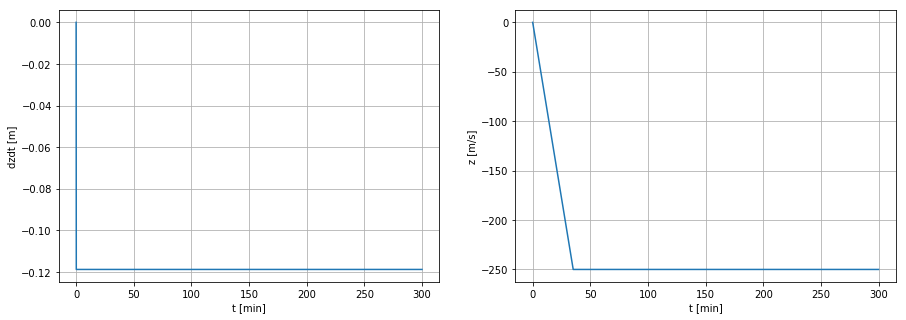

In [5]:
# we start by constructing a trajectory that can be followed by the float

# compute bounds on motions
fmax, fmin, afmax, wmax = fs.compute_bounds(w,-500.)

t = np.arange(0.,3600.*5,1.)

z_target = np.zeros_like(t)
dzdt_target = -t*afmax/fs.m
dzdt_target[np.where(-dzdt_target>wmax)]=-wmax
z_target = np.cumsum(dzdt_target*1.)
z_target[np.where(z_target<-250.)] = -250.
#z_target[:]=-250.


plt.figure(figsize=(15,5))

ax=plt.subplot(121)
#ax.plot(fs.X[:,0]/60.,fs.X[:,1])
ax.plot(t/60.,dzdt_target)
ax.set_xlabel('t [min]')
ax.set_ylabel('dzdt [m]')
ax.grid()
#
ax=plt.subplot(122)
ax.plot(t/60.,z_target)
#ax.plot(f.X[:,0]/60.,f.X[:,2])
#ax.plot(fs.X[:,0]/60.,fs.X[:,2])
ax.set_xlabel('t [min]')
ax.set_ylabel('z [m/s]')
ax.grid()


# convert to callable function
z_target = interp1d(t,z_target,kind='linear',fill_value='extrapolate')


In [6]:
# time step float with control
fs.time_step(w,T=600.,dt_step=.1,dt_store=1.,z=0.,w=0., \
             piston=True, z_target=z_target, tau_ctrl=1., dt_ctrl=1., d3y_ctrl=afmax/fs.m/1.)
#             piston=True,z_target=-250., w_target=0., dwdt_target=0., tau_ctrl=60., dt_ctrl=1.)


Start time stepping for 10 min ...
df1=-4.800255e-05 df2=-1.250000e-02 df3=3.116920e+03
df1*x2=-0.000000e+00 df2*f2=-4.412852e-04 df3*f3=0.000000e+00, d3y=-3.530281e-02
u=-1.118461e-05
df1=-4.775863e-05 df2=-2.009220e-02 df3=3.116920e+03
df1*x2=-1.861018e-07 df2*f2=-8.103669e-06 df3*f3=0.000000e+00, d3y=-3.530281e-02
u=-1.132352e-05
df1=-4.751168e-05 df2=-1.351840e-01 df3=3.116920e+03
df1*x2=1.284564e-06 df2*f2=4.464556e-03 df3*f3=-0.000000e+00, d3y=-3.530281e-02
u=-1.275896e-05
df1=-4.750786e-05 df2=-2.894423e-01 df3=3.116920e+03
df1*x2=2.750157e-06 df2*f2=7.820916e-03 df3*f3=-0.000000e+00, d3y=-3.530281e-02
u=-1.383625e-05
df1=-4.720611e-05 df2=-5.701869e-01 df3=3.116920e+03
df1*x2=5.383262e-06 df2*f2=2.623629e-02 df3*f3=-0.000000e+00, d3y=-3.530281e-02
u=-1.974529e-05
df1=-4.677549e-05 df2=-9.497789e-01 df3=3.116920e+03
df1*x2=8.885276e-06 df2*f2=4.735720e-02 df3*f3=-0.000000e+00, d3y=3.530281e-02
u=-3.870253e-06
df1=-4.669109e-05 df2=-1.147216e+00 df3=3.116920e+03
df1*x2=1.071296e-

df1=-4.407078e-05 df2=-2.272730e+00 df3=3.116920e+03
df1*x2=2.003220e-05 df2*f2=2.295437e-02 df3*f3=-0.000000e+00, d3y=-3.530281e-02
u=-1.869705e-05
df1=-4.366303e-05 df2=-2.406419e+00 df3=3.116920e+03
df1*x2=2.101431e-05 df2*f2=1.401021e-02 df3*f3=-0.000000e+00, d3y=-3.530281e-02
u=-1.582782e-05
df1=-4.331784e-05 df2=-2.510183e+00 df3=3.116920e+03
df1*x2=2.174715e-05 df2*f2=1.038994e-02 df3*f3=-0.000000e+00, d3y=-3.530281e-02
u=-1.466656e-05
df1=-4.299799e-05 df2=-2.601162e+00 df3=3.116920e+03
df1*x2=2.236895e-05 df2*f2=8.717083e-03 df3*f3=-0.000000e+00, d3y=-3.530281e-02
u=-1.413006e-05
df1=-4.268983e-05 df2=-2.685376e+00 df3=3.116920e+03
df1*x2=2.292765e-05 df2*f2=7.716802e-03 df3*f3=-0.000000e+00, d3y=-3.530281e-02
u=-1.380932e-05
df1=-4.238867e-05 df2=-2.764992e+00 df3=3.116920e+03
df1*x2=2.344086e-05 df2*f2=6.974360e-03 df3*f3=-0.000000e+00, d3y=-3.530281e-02
u=-1.357129e-05
df1=-4.209269e-05 df2=-2.840955e+00 df3=3.116920e+03
df1*x2=2.391669e-05 df2*f2=6.360127e-03 df3*f3=-0.000

df1=-4.269347e-05 df2=-2.684392e+00 df3=3.116920e+03
df1*x2=2.292120e-05 df2*f2=7.735637e-03 df3*f3=-0.000000e+00, d3y=-3.530281e-02
u=-1.381536e-05
df1=-4.239217e-05 df2=-2.764078e+00 df3=3.116920e+03
df1*x2=2.343505e-05 df2*f2=6.984037e-03 df3*f3=-0.000000e+00, d3y=-3.530281e-02
u=-1.357439e-05
df1=-4.209613e-05 df2=-2.840084e+00 df3=3.116920e+03
df1*x2=2.391131e-05 df2*f2=6.367131e-03 df3*f3=-0.000000e+00, d3y=-3.530281e-02
u=-1.337662e-05
df1=-4.180441e-05 df2=-2.912972e+00 df3=3.116920e+03
df1*x2=2.435501e-05 df2*f2=5.835338e-03 df3*f3=-0.000000e+00, d3y=-3.530281e-02
u=-1.320615e-05
df1=-4.151640e-05 df2=-2.983130e+00 df3=3.116920e+03
df1*x2=2.476977e-05 df2*f2=5.367643e-03 df3*f3=-0.000000e+00, d3y=-3.530281e-02
u=-1.305623e-05
df1=-4.123166e-05 df2=-3.050866e+00 df3=3.116920e+03
df1*x2=2.515845e-05 df2*f2=4.951951e-03 df3*f3=-0.000000e+00, d3y=-3.530281e-02
u=-1.292299e-05
df1=-4.094983e-05 df2=-3.116427e+00 df3=3.116920e+03
df1*x2=2.552343e-05 df2*f2=4.579780e-03 df3*f3=-0.000

df1=-4.770425e-05 df2=-6.134139e-01 df3=3.116920e+03
df1*x2=-5.852491e-06 df2*f2=2.757787e-02 df3*f3=0.000000e+00, d3y=-3.530281e-02
u=-2.017210e-05
df1=-4.726432e-05 df2=-1.958915e-01 df3=3.116920e+03
df1*x2=-1.851735e-06 df2*f2=1.450430e-02 df3*f3=0.000000e+00, d3y=-3.530281e-02
u=-1.597900e-05
df1=-4.691584e-05 df2=-3.711980e-01 df3=3.116920e+03
df1*x2=3.483014e-06 df2*f2=3.943297e-02 df3*f3=-0.000000e+00, d3y=-3.530281e-02
u=-2.397856e-05
df1=-4.639290e-05 df2=-1.043045e+00 df3=3.116920e+03
df1*x2=9.677980e-06 df2*f2=8.965532e-02 df3*f3=-0.000000e+00, d3y=-3.530281e-02
u=-4.009336e-05
df1=-4.551852e-05 df2=-1.640354e+00 df3=3.116920e+03
df1*x2=1.493330e-05 df2*f2=8.306985e-02 df3*f3=-0.000000e+00, d3y=-3.530281e-02
u=-3.798224e-05
df1=-4.469018e-05 df2=-2.034980e+00 df3=3.116920e+03
df1*x2=1.818872e-05 df2*f2=4.882107e-02 df3*f3=-0.000000e+00, d3y=-3.530281e-02
u=-2.699526e-05
df1=-4.410145e-05 df2=-2.260721e+00 df3=3.116920e+03
df1*x2=1.994021e-05 df2*f2=2.523263e-02 df3*f3=-0.000

df1*x2=-2.822778e-05 df2*f2=-7.845893e-03 df3*f3=0.000000e+00, d3y=3.530281e-02
u=1.385243e-05
df1=-5.308158e-05 df2=-2.754339e+00 df3=3.116920e+03
df1*x2=-2.924093e-05 df2*f2=-7.070137e-03 df3*f3=0.000000e+00, d3y=3.530281e-02
u=1.360387e-05
df1=-5.337827e-05 df2=-2.830781e+00 df3=3.116920e+03
df1*x2=-3.022044e-05 df2*f2=-6.439968e-03 df3*f3=0.000000e+00, d3y=3.530281e-02
u=1.340201e-05
df1=-5.367055e-05 df2=-2.904047e+00 df3=3.116920e+03
df1*x2=-3.117236e-05 df2*f2=-5.898889e-03 df3*f3=0.000000e+00, d3y=3.530281e-02
u=1.322872e-05
df1=-5.395905e-05 df2=-2.974542e+00 df3=3.116920e+03
df1*x2=-3.210068e-05 df2*f2=-5.423873e-03 df3*f3=0.000000e+00, d3y=3.530281e-02
u=1.307662e-05
df1=-5.424423e-05 df2=-3.042578e+00 df3=3.116920e+03
df1*x2=-3.300846e-05 df2*f2=-5.002130e-03 df3*f3=0.000000e+00, d3y=-3.530281e-02
u=-9.710763e-06
df1=-5.403245e-05 df2=-2.997107e+00 df3=3.116920e+03
df1*x2=-3.238821e-05 df2*f2=3.478687e-03 df3*f3=0.000000e+00, d3y=-3.530281e-02
u=-1.243186e-05
df1=-5.376133e

df1*x2=2.563804e-05 df2*f2=-4.155247e-03 df3*f3=-0.000000e+00, d3y=3.530281e-02
u=1.265108e-05
df1=-4.116310e-05 df2=-3.071892e+00 df3=3.116920e+03
df1*x2=2.528972e-05 df2*f2=-4.459218e-03 df3*f3=-0.000000e+00, d3y=3.530281e-02
u=1.274872e-05
df1=-4.144113e-05 df2=-3.006755e+00 df3=3.116920e+03
df1*x2=2.492066e-05 df2*f2=-4.791672e-03 df3*f3=-0.000000e+00, d3y=3.530281e-02
u=1.285550e-05
df1=-4.172149e-05 df2=-2.939640e+00 df3=3.116920e+03
df1*x2=2.452923e-05 df2*f2=-5.156326e-03 df3*f3=-0.000000e+00, d3y=3.530281e-02
u=1.297262e-05
df1=-4.200440e-05 df2=-2.870358e+00 df3=3.116920e+03
df1*x2=2.411354e-05 df2*f2=-5.557563e-03 df3*f3=-0.000000e+00, d3y=3.530281e-02
u=1.310148e-05
df1=-4.229013e-05 df2=-2.798691e+00 df3=3.116920e+03
df1*x2=2.367141e-05 df2*f2=-6.000592e-03 df3*f3=-0.000000e+00, d3y=3.530281e-02
u=1.324376e-05
df1=-4.257896e-05 df2=-2.724383e+00 df3=3.116920e+03
df1*x2=2.320028e-05 df2*f2=-6.491649e-03 df3*f3=-0.000000e+00, d3y=3.530281e-02
u=1.340145e-05
df1=-4.287123e-05

df1=-4.858000e-05 df2=-1.179207e+00 df3=3.116920e+03
df1*x2=-1.145717e-05 df2*f2=2.502338e-02 df3*f3=0.000000e+00, d3y=-3.530281e-02
u=-1.935075e-05
df1=-4.815798e-05 df2=-9.336143e-01 df3=3.116920e+03
df1*x2=-8.992196e-06 df2*f2=2.767792e-02 df3*f3=0.000000e+00, d3y=-3.530281e-02
u=-2.020319e-05
df1=-4.771738e-05 df2=-6.238368e-01 df3=3.116920e+03
df1*x2=-5.953571e-06 df2*f2=2.768051e-02 df3*f3=0.000000e+00, d3y=-3.530281e-02
u=-2.020500e-05
df1=-4.727673e-05 df2=-2.102414e-01 df3=3.116920e+03
df1*x2=-1.987905e-06 df2*f2=1.531644e-02 df3*f3=0.000000e+00, d3y=-3.530281e-02
u=-1.623951e-05
df1=-4.692257e-05 df2=-3.540604e-01 df3=3.116920e+03
df1*x2=3.322685e-06 df2*f2=3.771201e-02 df3*f3=-0.000000e+00, d3y=-3.530281e-02
u=-2.342638e-05
df1=-4.641167e-05 df2=-1.025755e+00 df3=3.116920e+03
df1*x2=9.521402e-06 df2*f2=8.908642e-02 df3*f3=-0.000000e+00, d3y=-3.530281e-02
u=-3.991079e-05
df1=-4.554127e-05 df2=-1.627656e+00 df3=3.116920e+03
df1*x2=1.482511e-05 df2*f2=8.388804e-02 df3*f3=-0.000

df1=-4.650273e-05 df2=-1.395516e+00 df3=3.116920e+03
df1*x2=1.297906e-05 df2*f2=-2.190071e-02 df3*f3=-0.000000e+00, d3y=3.530281e-02
u=1.834841e-05
df1=-4.690289e-05 df2=-1.194336e+00 df3=3.116920e+03
df1*x2=1.120356e-05 df2*f2=-2.482022e-02 df3*f3=-0.000000e+00, d3y=3.530281e-02
u=1.928565e-05
df1=-4.732348e-05 df2=-9.521956e-01 df3=3.116920e+03
df1*x2=9.012242e-06 df2*f2=-2.753482e-02 df3*f3=-0.000000e+00, d3y=3.530281e-02
u=2.015728e-05
df1=-4.776308e-05 df2=-6.478233e-01 df3=3.116920e+03
df1*x2=6.188408e-06 df2*f2=-2.788598e-02 df3*f3=-0.000000e+00, d3y=3.530281e-02
u=2.027084e-05
df1=-4.820516e-05 df2=-2.431618e-01 df3=3.116920e+03
df1*x2=2.344331e-06 df2*f2=-1.706352e-02 df3*f3=-0.000000e+00, d3y=3.530281e-02
u=1.679991e-05
df1=-4.857155e-05 df2=-3.135591e-01 df3=3.116920e+03
df1*x2=-3.046010e-06 df2*f2=-3.348586e-02 df3*f3=0.000000e+00, d3y=3.530281e-02
u=2.207042e-05
df1=-4.905287e-05 df2=-9.829154e-01 df3=3.116920e+03
df1*x2=-9.642965e-06 df2*f2=-8.728702e-02 df3*f3=0.000000e+

df1=-3.958675e-05 df2=-3.415491e+00 df3=3.116920e+03
df1*x2=2.704164e-05 df2*f2=3.193981e-03 df3*f3=-0.000000e+00, d3y=-3.530281e-02
u=-1.235958e-05
df1=-3.931721e-05 df2=-3.471539e+00 df3=3.116920e+03
df1*x2=2.729824e-05 df2*f2=2.982146e-03 df3*f3=-0.000000e+00, d3y=-3.530281e-02
u=-1.229170e-05
df1=-3.904914e-05 df2=-3.526385e+00 df3=3.116920e+03
df1*x2=2.754046e-05 df2*f2=2.787281e-03 df3*f3=-0.000000e+00, d3y=-3.530281e-02
u=-1.222926e-05
df1=-3.878244e-05 df2=-3.580110e+00 df3=3.116920e+03
df1*x2=2.776908e-05 df2*f2=2.607616e-03 df3*f3=-0.000000e+00, d3y=-3.530281e-02
u=-1.217169e-05
df1=-3.851699e-05 df2=-3.632786e+00 df3=3.116920e+03
df1*x2=2.798479e-05 df2*f2=2.441620e-03 df3*f3=-0.000000e+00, d3y=-3.530281e-02
u=-1.211851e-05
df1=-3.825270e-05 df2=-3.684476e+00 df3=3.116920e+03
df1*x2=2.818824e-05 df2*f2=2.287967e-03 df3*f3=-0.000000e+00, d3y=-3.530281e-02
u=-1.206928e-05
df1=-3.798949e-05 df2=-3.735241e+00 df3=3.116920e+03
df1*x2=2.837998e-05 df2*f2=2.145496e-03 df3*f3=-0.000

df1*x2=-3.504914e-05 df2*f2=3.891035e-03 df3*f3=0.000000e+00, d3y=-3.530281e-02
u=-1.256330e-05
df1=-5.460729e-05 df2=-3.131443e+00 df3=3.116920e+03
df1*x2=-3.419992e-05 df2*f2=4.171707e-03 df3*f3=0.000000e+00, d3y=-3.530281e-02
u=-1.265362e-05
df1=-5.433133e-05 df2=-3.068029e+00 df3=3.116920e+03
df1*x2=-3.333802e-05 df2*f2=4.477293e-03 df3*f3=0.000000e+00, d3y=-3.530281e-02
u=-1.275194e-05
df1=-5.405323e-05 df2=-3.002793e+00 df3=3.116920e+03
df1*x2=-3.246213e-05 df2*f2=4.811493e-03 df3*f3=0.000000e+00, d3y=-3.530281e-02
u=-1.285944e-05
df1=-5.377278e-05 df2=-2.935568e+00 df3=3.116920e+03
df1*x2=-3.157074e-05 df2*f2=5.178118e-03 df3*f3=0.000000e+00, d3y=-3.530281e-02
u=-1.297735e-05
df1=-5.348977e-05 df2=-2.866165e+00 df3=3.116920e+03
df1*x2=-3.066210e-05 df2*f2=5.581602e-03 df3*f3=0.000000e+00, d3y=-3.530281e-02
u=-1.310709e-05
df1=-5.320392e-05 df2=-2.794362e+00 df3=3.116920e+03
df1*x2=-2.973420e-05 df2*f2=6.027211e-03 df3*f3=0.000000e+00, d3y=-3.530281e-02
u=-1.325035e-05
df1=-5.291

u=1.189077e-05
df1=-3.770006e-05 df2=-3.791630e+00 df3=3.116920e+03
df1*x2=2.858894e-05 df2*f2=-1.910421e-03 df3*f3=-0.000000e+00, d3y=3.530281e-02
u=1.192993e-05
df1=-3.796024e-05 df2=-3.742326e+00 df3=3.116920e+03
df1*x2=2.841192e-05 df2*f2=-2.032077e-03 df3*f3=-0.000000e+00, d3y=3.530281e-02
u=1.196902e-05
df1=-3.822126e-05 df2=-3.692203e+00 df3=3.116920e+03
df1*x2=2.822413e-05 df2*f2=-2.161929e-03 df3*f3=-0.000000e+00, d3y=3.530281e-02
u=1.201074e-05
df1=-3.848320e-05 df2=-3.641217e+00 df3=3.116920e+03
df1*x2=2.802514e-05 df2*f2=-2.301189e-03 df3*f3=-0.000000e+00, d3y=3.530281e-02
u=1.205548e-05
df1=-3.874612e-05 df2=-3.589319e+00 df3=3.116920e+03
df1*x2=2.781444e-05 df2*f2=-2.450740e-03 df3*f3=-0.000000e+00, d3y=3.530281e-02
u=1.210353e-05
df1=-3.901008e-05 df2=-3.536455e+00 df3=3.116920e+03
df1*x2=2.759147e-05 df2*f2=-2.611545e-03 df3*f3=-0.000000e+00, d3y=3.530281e-02
u=1.215519e-05
df1=-3.927517e-05 df2=-3.482565e+00 df3=3.116920e+03
df1*x2=2.735566e-05 df2*f2=-2.784680e-03 df3

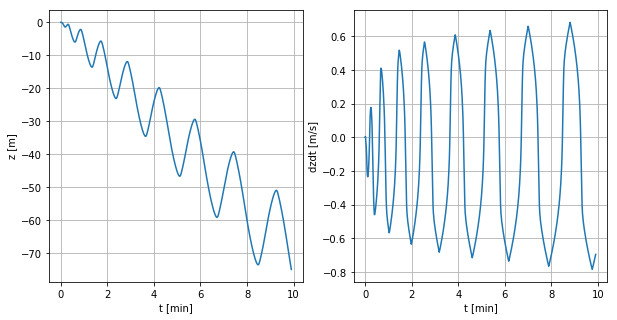

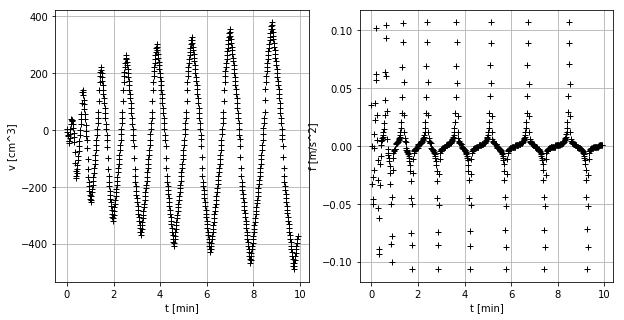

In [7]:
il=-5

plt.figure(figsize=(10,5))
ax=plt.subplot(121)
#ax.plot(fs.X[:,0]/60.,fs.X[:,1])
ax.plot(fs.X[:il,0]/60.,fs.X[:il,1])
ax.set_xlabel('t [min]')
ax.set_ylabel('z [m]')
ax.grid()
#
ax=plt.subplot(122)
#ax.plot(f.X[:,0]/60.,f.X[:,2])
ax.plot(fs.X[:il,0]/60.,fs.X[:il,2])
ax.set_xlabel('t [min]')
ax.set_ylabel('dzdt [m/s]')
ax.grid()

plt.figure(figsize=(10,5))
ax=plt.subplot(121)
#ax.plot(f.X[:,0]/60.,f.X[:,1])
ax.plot(fs.X[:il,0]/60.,fs.X[:il,3]*1.e6,'k+',lw=2)
ax.set_xlabel('t [min]')
ax.set_ylabel('v [cm^3]')
#ax.set_ylim((-255,-245))
ax.grid()

ax=plt.subplot(122)
#ax.plot(f.X[:,0]/60.,f.X[:,1])
ax.plot(fs.X[:il,0]/60.,fs.X[:il,4],'k+',lw=2)
ax.set_xlabel('t [min]')
ax.set_ylabel('f [m/s^2]')
#ax.set_ylim((-255,-245))
ax.grid()